# Adhering to constraints

This notebook explains our approach to `smallness regularization`, with the goal of adhering to prior knowledge of topography we're aiming to recover. In the scenario of a sediment-basement contact inversion, if we know the basement depth at a few points from drill holes or seismic data, we want the inverted results to adhere to these points, which we refer to as `constraints`. 

Again, we will use the same synthetic data from the past two user guides. 

## Import packages

In [1]:
from __future__ import annotations

%load_ext autoreload
%autoreload 2

import logging

import numpy as np
import pandas as pd
import verde as vd
import xarray as xr
from polartoolkit import utils as polar_utils

from invert4geom import (
    cross_validation,
    plotting,
    regional,
    synthetic,
    utils,
)

## Create observed gravity data
To run the inversion, we need to have observed gravity data. In this simple example, we will first create a synthetic topography, which represents the `true` Earth topography which we hope to recover during the inverison. From this topography, we will create a layer of vertical right-rectangular prisms, which allows us to calculated the gravity effect of the topography. This will act as our observed gravity data. 

### True topography

In [2]:
# set grid parameters
spacing = 1000
region = [0, 40000, 0, 30000]

# create synthetic topography data
true_topography = synthetic.synthetic_topography_simple(
    spacing,
    region,
)

### Starting topography

Sample the starting topography at 10 random locations and regrid with those sampled values. This sumulates only knowing the depth to this topography at 10 boreholes.

In [3]:
# create 10 random point withing the region
num_constraints = 10
coords = vd.scatter_points(region=region, size=num_constraints, random_state=7)
constraint_points = pd.DataFrame(data={"easting": coords[0], "northing": coords[1]})

# sample true topography at these points
constraint_points = utils.sample_grids(
    constraint_points, true_topography, "upward", coord_names=("easting", "northing")
)

# grid the sampled values using verde
starting_topography = utils.create_topography(
    method="splines",
    region=region,
    spacing=spacing,
    constraints_df=constraint_points,
    dampings=np.logspace(-20, 0, 100),
)

# re-sample the starting topography at the constraint points to see how the gridded did
constraint_points = utils.sample_grids(
    constraint_points,
    starting_topography,
    "starting_topography",
    coord_names=("easting", "northing"),
)

rmse = utils.rmse(constraint_points.upward - constraint_points.starting_topography)
print(f"RMSE at the constraints between the starting and true topography: {rmse:.2f} m")

constraint_points

RMSE at the constraints between the starting and true topography: 19.26 m


,easting,northing,upward,starting_topography
0,3052.331575,20376.899884,619.779099,580.163740
1,31196.751690,24112.171083,479.563412,481.652035
2,17536.369258,11428.233994,465.786893,458.230368
3,28938.607113,1978.090407,426.413502,438.512760
4,39119.580480,8644.367979,428.773305,425.210470
5,21539.834816,27287.805832,546.901160,547.287244
6,20044.818546,6401.560607,450.406755,455.069067
7,2882.045334,13563.718855,460.979806,499.138482
8,10737.559204,27936.180591,614.084318,624.948915
9,19995.300033,746.976827,470.409607,452.397262


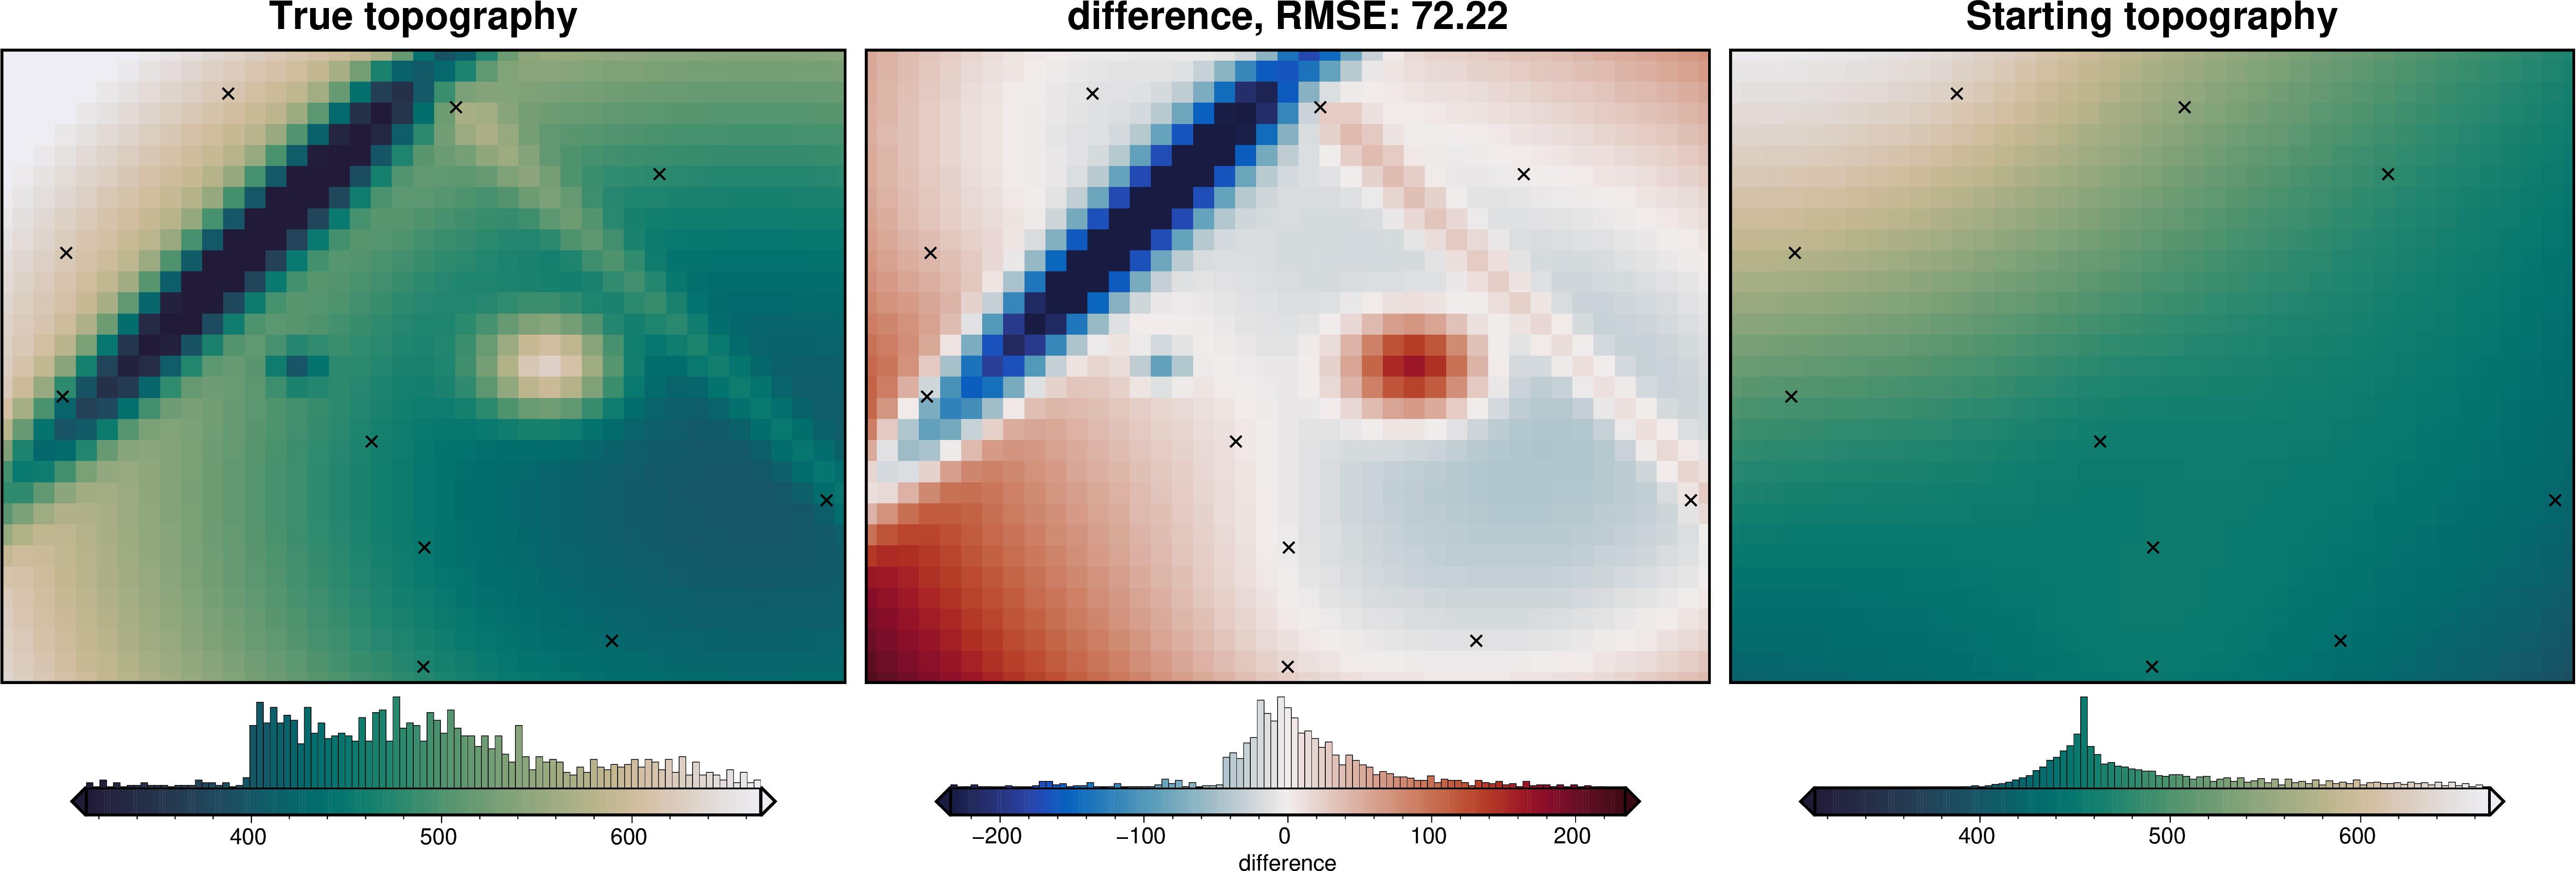

In [4]:
_ = polar_utils.grd_compare(
    true_topography,
    starting_topography,
    plot=True,
    grid1_name="True topography",
    grid2_name="Starting topography",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
    points_style="x.3c",
)

### Prism layer

In [5]:
# the density contrast is between rock (~2670 kg/m3) and air (~1 kg/m3)
density_contrast = 2670 - 1

# prisms are created between the mean topography value and the height of the topography
zref = true_topography.values.mean()

# prisms above zref have positive density contrast and prisms below zref have negative
# density contrast
density_grid = xr.where(true_topography >= zref, density_contrast, -density_contrast)

# create layer of prisms
prisms = utils.grids_to_prisms(
    true_topography,
    zref,
    density=density_grid,
)

### Forward gravity of prism layer

In [6]:
# make pandas dataframe of locations to calculate gravity
# this represents the station locations of a gravity survey
# create lists of coordinates
coords = vd.grid_coordinates(
    region=region,
    spacing=spacing,
    pixel_register=False,
    extra_coords=1000,  # survey elevation
)

# grid the coordinates
observations = vd.make_xarray_grid(
    (coords[0], coords[1]),
    data=coords[2],
    data_names="upward",
    dims=("northing", "easting"),
).upward

grav_df = vd.grid_to_table(observations)

grav_df["grav"] = prisms.prism_layer.gravity(
    coordinates=(
        grav_df.easting,
        grav_df.northing,
        grav_df.upward,
    ),
    field="g_z",
    progressbar=True,
)
grav_df

  0%|          | 0/1271 [00:00<?, ?it/s]

,northing,easting,upward,grav
0,0.0,0.0,1000.0,9.534643
1,0.0,1000.0,1000.0,10.422834
2,0.0,2000.0,1000.0,9.949973
3,0.0,3000.0,1000.0,9.269279
4,0.0,4000.0,1000.0,8.532160
...,...,...,...,...
1266,30000.0,36000.0,1000.0,3.332716
1267,30000.0,37000.0,1000.0,3.330307
1268,30000.0,38000.0,1000.0,3.335438
1269,30000.0,39000.0,1000.0,3.300721


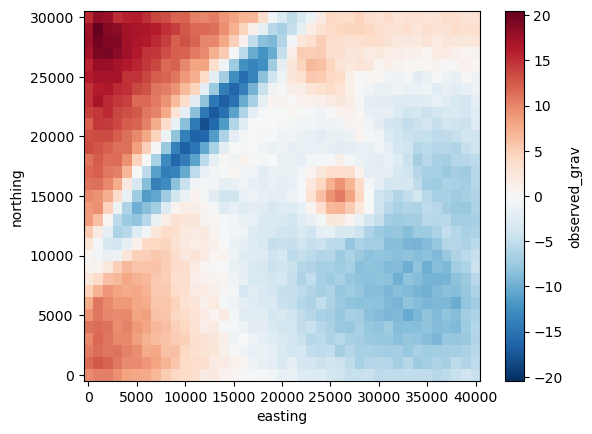

In [7]:
# contaminate gravity with 0.5 mGal of random noise
grav_df["observed_grav"], stddev = synthetic.contaminate(
    grav_df.grav,
    stddev=0.5,
    percent=False,
    seed=0,
)

grav_df.set_index(["northing", "easting"]).to_xarray().observed_grav.plot()

### Resample to create testing / training data sets

Note that it is important to do this resampling on the original observed gravity data *before* you calculate your misfit!

In [8]:
# resample to half spacing
grav_df = cross_validation.resample_with_test_points(spacing, grav_df, region)
grav_df

,northing,easting,test,upward,grav,observed_grav
0,0.0,0.0,False,1000.0,9.534643,9.617711
1,0.0,500.0,True,1000.0,10.063805,10.050215
2,0.0,1000.0,False,1000.0,10.422834,10.376985
3,0.0,1500.0,True,1000.0,10.284459,10.440419
4,0.0,2000.0,False,1000.0,9.949973,10.290387
...,...,...,...,...,...,...
4936,30000.0,38000.0,False,1000.0,3.335438,3.501867
4937,30000.0,38500.0,True,1000.0,3.346051,3.145170
4938,30000.0,39000.0,False,1000.0,3.300721,2.848068
4939,30000.0,39500.0,True,1000.0,3.104991,2.936345


## Gravity misfit
Now we need to calculate the forward gravity of the starting topography. We then can subtract it from our observed gravity to get a starting gravity misfit.

In [9]:
# for a reference level we use the mean value of the true topography
# zref = starting_topography.values.mean()

# prisms above zref have positive density contrast and prisms below zref have negative
# density contrast
density_grid = xr.where(
    starting_topography >= zref, density_contrast, -density_contrast
)

# create layer of prisms
starting_prisms = utils.grids_to_prisms(
    starting_topography,
    reference=zref,
    density=density_grid,
)

# calculate forward gravity of starting prism layer
grav_df["starting_grav"] = starting_prisms.prism_layer.gravity(
    coordinates=(
        grav_df.easting,
        grav_df.northing,
        grav_df.upward,
    ),
    field="g_z",
    progressbar=True,
)

# calculate misfit as observed - starting
grav_df["misfit"] = grav_df["observed_grav"] - grav_df["starting_grav"]

# estimate regional with the median misfit at constraints
grav_df = regional.regional_dc_shift(
    grav_df=grav_df,
    grav_data_column="observed_grav",
    constraints_df=constraint_points,
    regional_column="reg",
)

# set the residual misfit to the full misfit
grav_df["res"] = grav_df.misfit

grav_df

  0%|          | 0/4941 [00:00<?, ?it/s]

,northing,easting,test,upward,grav,observed_grav,starting_grav,misfit,reg,res
0,0.0,0.0,False,1000.0,9.534643,9.617711,-4.354723,13.972435,-2.588061,13.972435
1,0.0,500.0,True,1000.0,10.063805,10.050215,-4.948974,14.999189,-2.588061,14.999189
2,0.0,1000.0,False,1000.0,10.422834,10.376985,-5.168392,15.545377,-2.588061,15.545377
3,0.0,1500.0,True,1000.0,10.284459,10.440419,-5.259174,15.699593,-2.588061,15.699593
4,0.0,2000.0,False,1000.0,9.949973,10.290387,-5.295486,15.585873,-2.588061,15.585873
...,...,...,...,...,...,...,...,...,...,...
4936,30000.0,38000.0,False,1000.0,3.335438,3.501867,-1.218445,4.720312,-2.588061,4.720312
4937,30000.0,38500.0,True,1000.0,3.346051,3.145170,-1.360153,4.505323,-2.588061,4.505323
4938,30000.0,39000.0,False,1000.0,3.300721,2.848068,-1.478901,4.326969,-2.588061,4.326969
4939,30000.0,39500.0,True,1000.0,3.104991,2.936345,-1.544151,4.480496,-2.588061,4.480496


## Weighting grid
To force the invesion to adhere to the starting model we need to supply a weighting grid. At each iteration, the `correction grid` is multiplied by this weighting grid to alter the iteration's correction. Therefore, this weighting grid should be ~0 at the constraints, so that they aren't altered from the starting model. These values should increase to ~1 at a distance to allow the inversion to be un-affected at locations far from constraints. 

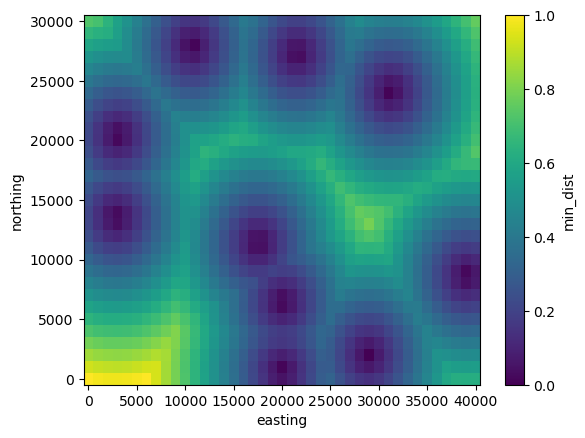

In [10]:
# calculate the distance between each grid cell and the nearest constraint, then
# normalize those values between 0 and 1
weighting_grid = utils.normalized_mindist(
    constraint_points,
    starting_prisms,
    low=0,
    high=1,
)
weighting_grid.plot()

## Perform inversion
Now we can perform the inversion, supplying the argument `apply_weighting_grid=True` and ensuring that the weighting grid is included as the `weights` variable to the argument `prism_layer`. Note that we have increased the `max_iterations` since at each iteration, the correction to apply to the prisms will be scaled down by the weighting grid, resulting in needing more iterations. Also, we will perform a damping parameter cross-validation, since we will likely need a different amount of damping since the weighting grid is being used.

In [11]:
# set Python's logging level
logger = logging.getLogger()
logger.setLevel(logging.WARNING)

# set which damping parameters to include
dampings = np.logspace(-3, 0, 6)

kwargs = {
    "grav_data_column": "observed_grav",
    "prism_layer": starting_prisms,
    "zref": zref,
    "density_contrast": density_contrast,
    # choose the small prism approximation method for calculating the vertical
    # derivative of gravity
    "deriv_type": "annulus",
    # set stopping criteria
    "max_iterations": 200,
    "l2_norm_tolerance": 0.5,
    "delta_l2_norm_tolerance": 1.002,
    # enable the use of weights
    "apply_weighting_grid": True,
    "weighting_grid": weighting_grid,
}
inv_results, best_damping, _, _, scores = cross_validation.grav_optimal_parameter(
    training_data=grav_df[grav_df.test == False],  # noqa: E712
    testing_data=grav_df[grav_df.test == True],  # noqa: E712
    param_to_test=("solver_damping", dampings),
    progressbar=True,
    plot_grids=False,
    plot_cv=False,
    verbose=True,
    **kwargs,
)

solver_damping values:   0%|          | 0/6 [00:00<?, ?it/s]

Iteration:   0%|          | 1/200 [00:00<?, ?it/s]

Iteration:   0%|          | 1/200 [00:00<?, ?it/s]

Iteration:   0%|          | 1/200 [00:00<?, ?it/s]

Iteration:   0%|          | 1/200 [00:00<?, ?it/s]

Iteration:   0%|          | 1/200 [00:00<?, ?it/s]

Iteration:   0%|          | 1/200 [00:00<?, ?it/s]

INFO:root:solver_damping value: 0.001 -> Score: 1.1801669339722445
INFO:root:solver_damping value: 0.003981071705534973 -> Score: 0.6235849047084255
INFO:root:solver_damping value: 0.015848931924611134 -> Score: 0.24036373032559863
INFO:root:solver_damping value: 0.0630957344480193 -> Score: 0.21148019722154845
INFO:root:solver_damping value: 0.25118864315095796 -> Score: 0.41912135941078804
INFO:root:solver_damping value: 1.0 -> Score: 6.909496206909026
INFO:root:Best score of 0.21148019722154845 with solver_damping=0.0630957344480193


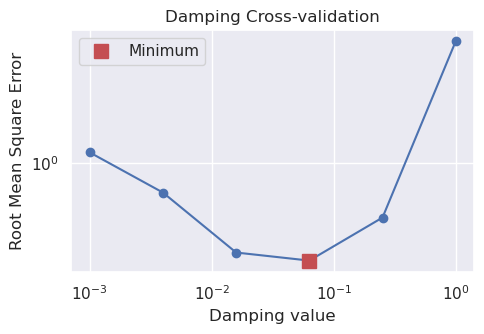

In [12]:
# Compare the scores and the damping values
plotting.plot_cv_scores(
    scores,
    dampings,
    param_name="Damping",
    logx=True,
    logy=True,
)

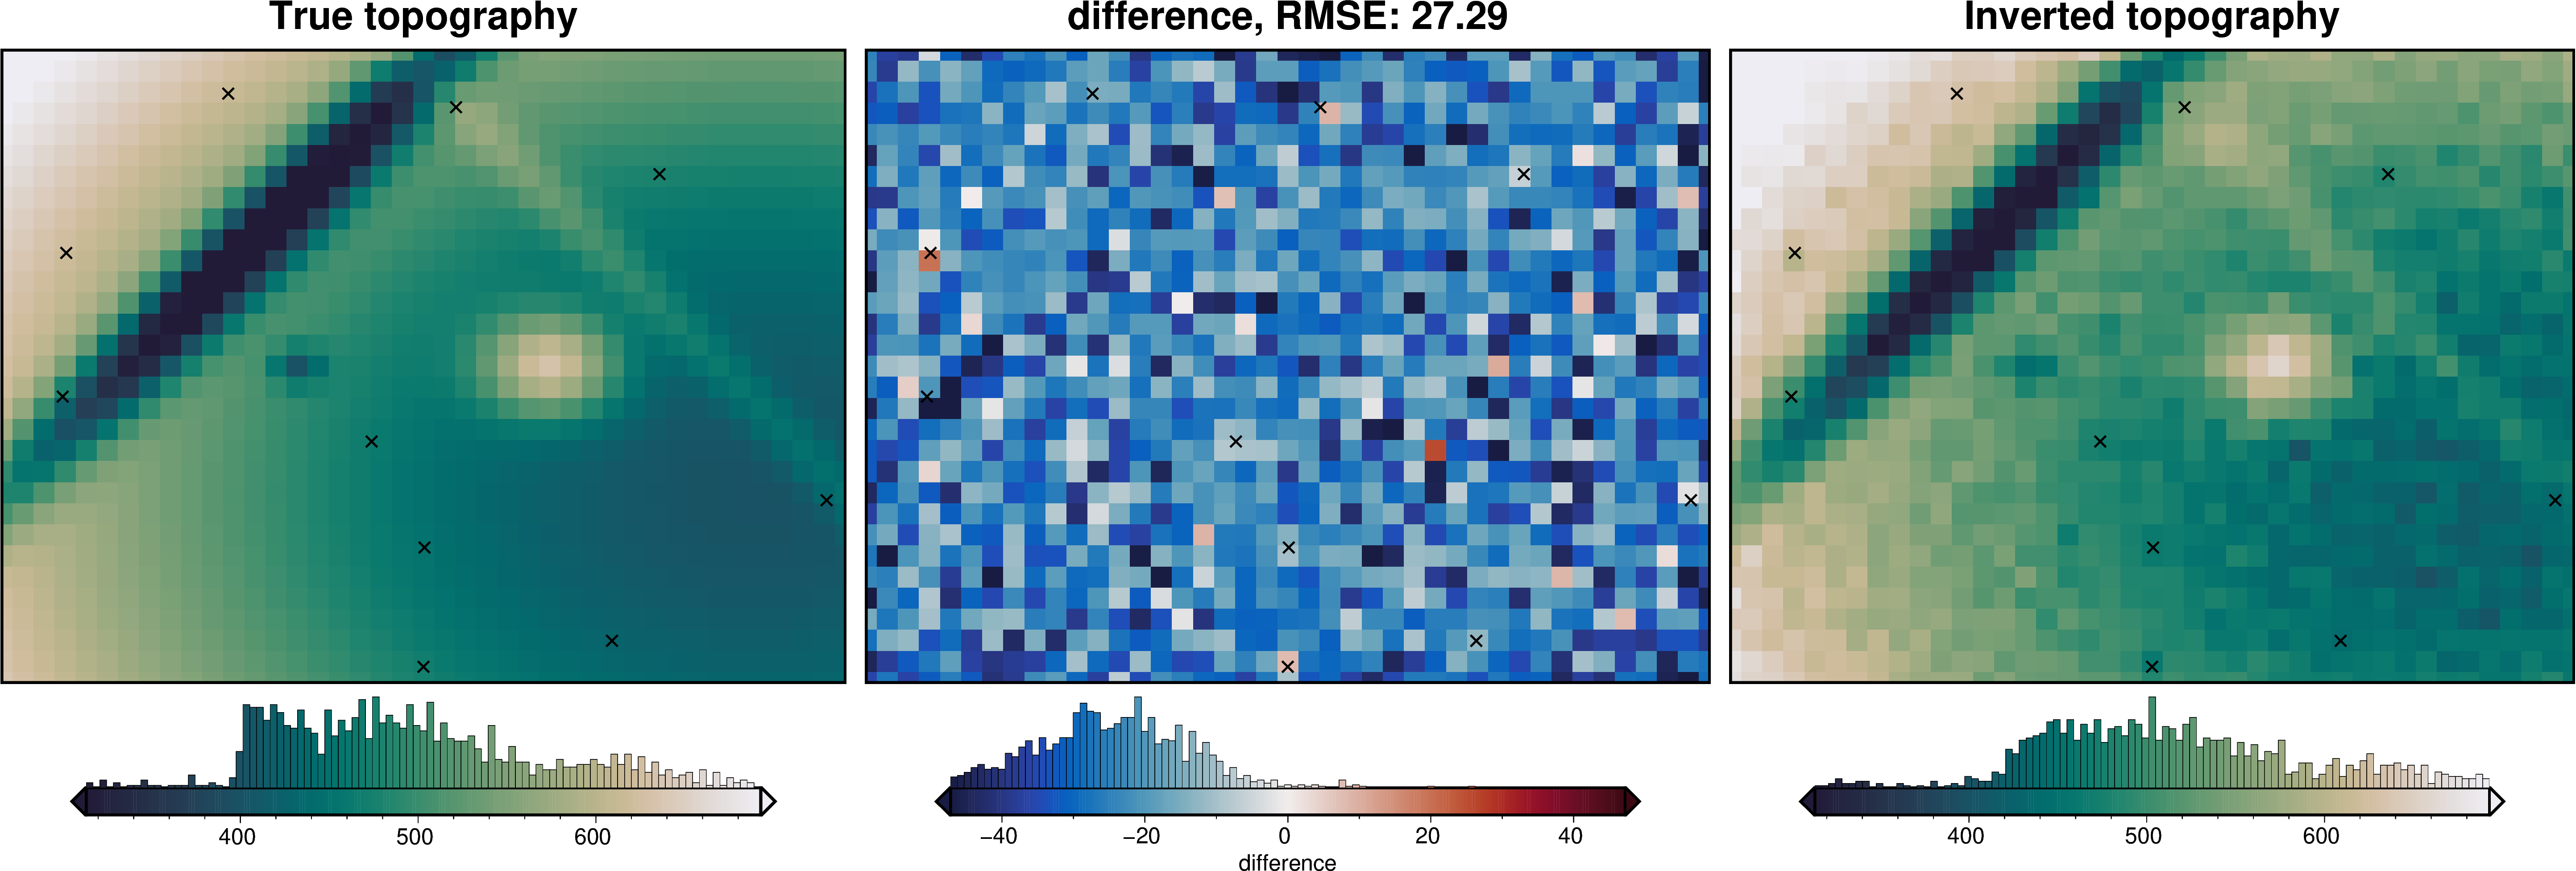

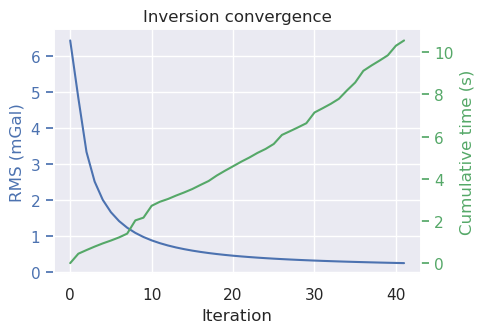

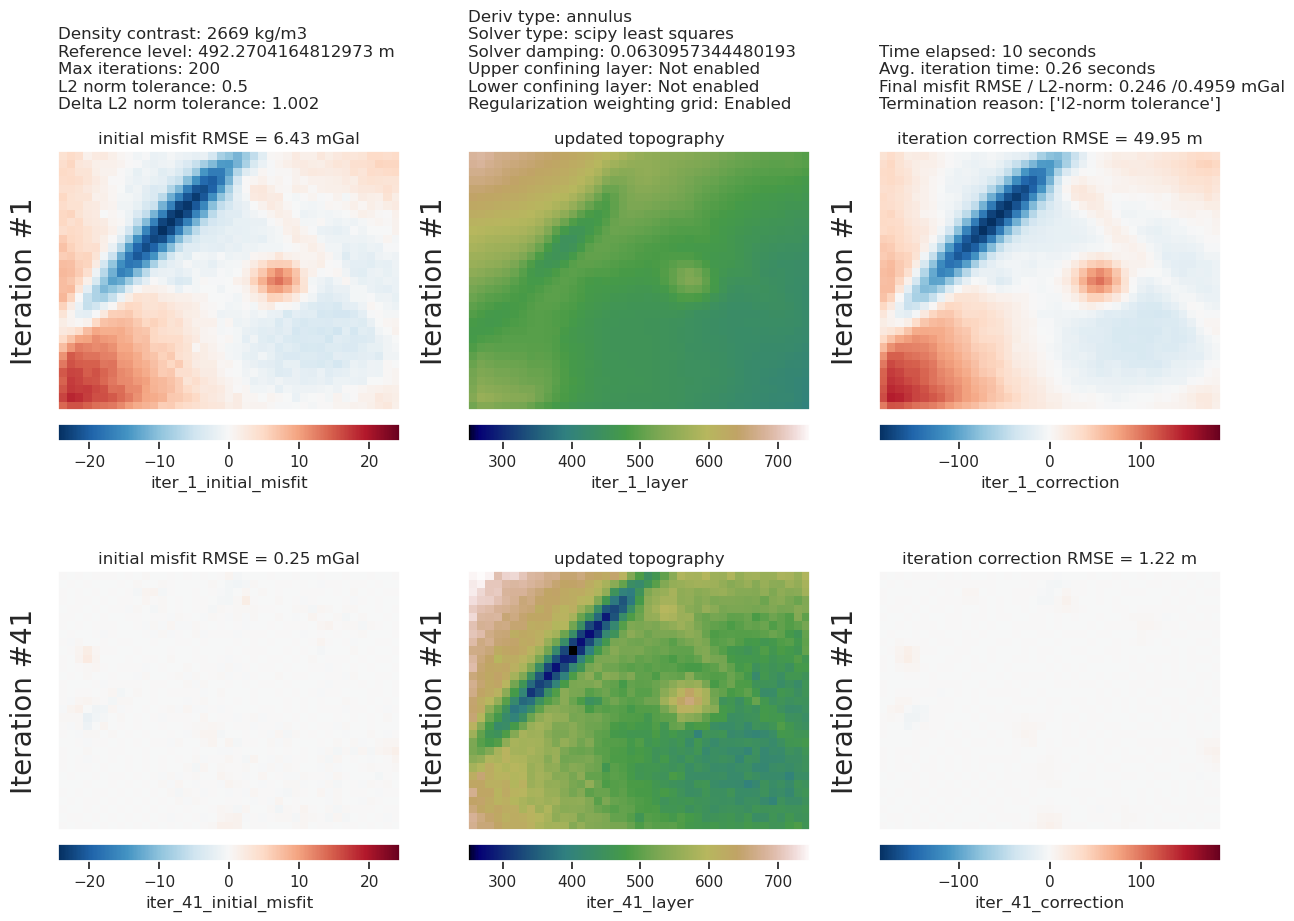

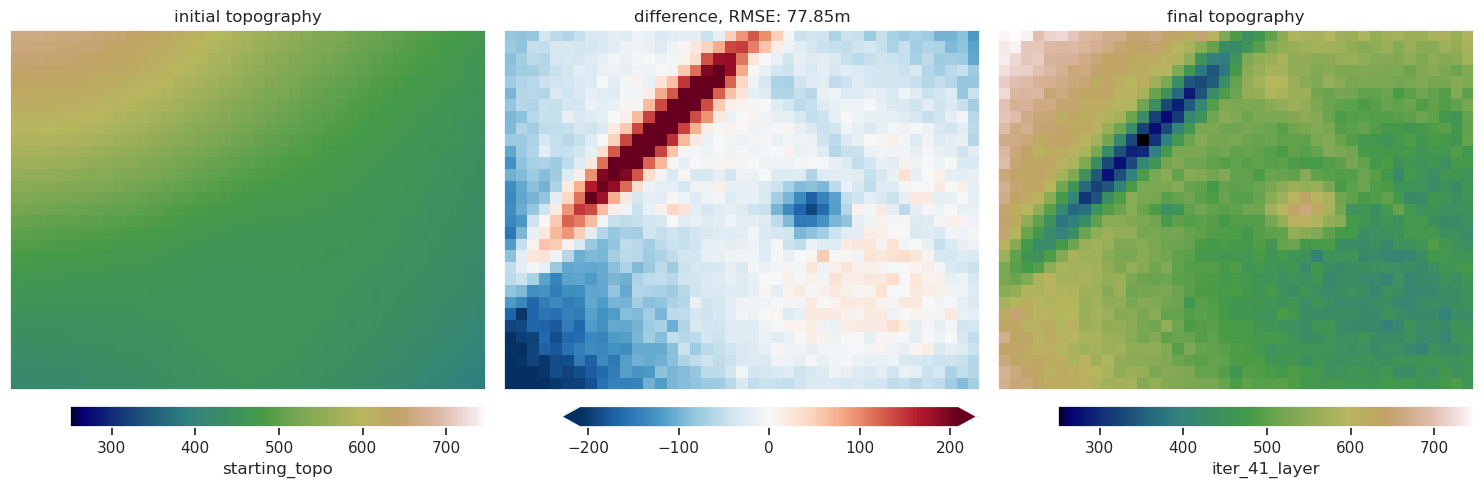

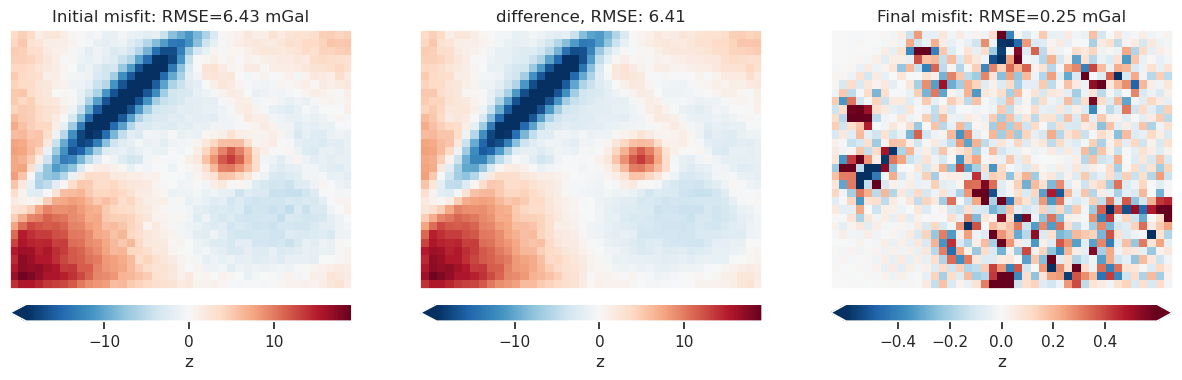

In [13]:
# collect the results
topo_results, grav_results, parameters, elapsed_time = inv_results

plotting.plot_convergence(
    grav_results,
    iter_times=parameters["Iteration times"],
)

plotting.plot_inversion_results(
    grav_results,
    topo_results,
    parameters,
    region,
    iters_to_plot=2,
    plot_iter_results=True,
    plot_topo_results=True,
    plot_grav_results=True,
)

final_topography = topo_results.set_index(["northing", "easting"]).to_xarray().topo

_ = polar_utils.grd_compare(
    true_topography,
    final_topography,
    plot=True,
    grid1_name="True topography",
    grid2_name="Inverted topography",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
    # diff_lims=(-20, 20),
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
    points_style="x.3c",
)

As we can see by the low error values surrounding the constraints (black crosses), include the weighting grid has help the inversion adhere to the constraints. We can sample the inverted topography at the constraints and compare with the constraints true values.

In [14]:
# sample the inverted topography at the constraint points
constraint_points = utils.sample_grids(
    constraint_points,
    final_topography,
    "inverted_topography",
    coord_names=("easting", "northing"),
)

rmse = utils.rmse(constraint_points.upward - constraint_points.inverted_topography)
print(f"RMSE: {rmse:.2f} m")

RMSE: 14.24 m


In [15]:
constraint_points

,easting,northing,upward,starting_topography,inverted_topography
0,3052.331575,20376.899884,619.779099,580.163740,603.812440
1,31196.751690,24112.171083,479.563412,481.652035,486.316873
2,17536.369258,11428.233994,465.786893,458.230368,472.588284
3,28938.607113,1978.090407,426.413502,438.512760,438.613800
4,39119.580480,8644.367979,428.773305,425.210470,434.867593
5,21539.834816,27287.805832,546.901160,547.287244,555.575978
6,20044.818546,6401.560607,450.406755,455.069067,459.644026
7,2882.045334,13563.718855,460.979806,499.138482,492.781111
8,10737.559204,27936.180591,614.084318,624.948915,631.084542
9,19995.300033,746.976827,470.409607,452.397262,464.471730


While this inversion's results are very similar as the past example (`including_starting_model.ipynb`), the RMSE at the constraint points is much more, showing the inversion is correctly adhering to these constraints.

Note at we increased the max iterations allowed. This is necessary since with the weighting grid we require many more iterations to get to a similar outcome.

#